# The Fermi-Pasta-Ulam-Tsingou Problem (2D)
## Set up

In [1]:
"""
================================================================================
                The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (2D)                
================================================================================
"""
#   Standard libraries
import glob
from IPython.display import display, Video
from math import log10
import os
from pathlib import Path
import re

#   Third-party libraries
from matplotlib.animation import FuncAnimation
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import pi as PI
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from numba import jit       #   Importing Numba for performance
                            #   optimization where applicable

__version__ = '1.0'

#   Setting up Matplotlib's color cycle for more color-friendly visuals
#   https://gist.github.com/thriveth/8560036
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = CB_color_cycle)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", CB_color_cycle)
del CB_color_cycle


In [2]:
################################################################################
#                            CONSTANTS & PARAMETERS                            #
################################################################################

N, ALPHA, BETA, N_MODES, CONFIG_STR, DT, TIME_POINTS = (None,) * 7

def init_constants(temp_N = 2 ** 6, temp_ALPHA = 1.0, temp_BETA = 1e-1,
                   temp_N_MODES = 3, temp_t_max = 1e5, temp_dt_mantissa = 2.5,
                   temp_dt_exp = -2):
    """
    Initialize simulation constants and parameters with either default or provided
    values. Creates necessary directories for simulation data

    Parameters:
    - temp_N:           Number of masses
    - temp_ALPHA:       Linear spring constant
    - temp_BETA:        Nonlinear spring constant
    - temp_N_MODES:     Number of initial modes
    - temp_t_max:       Maximum simulation time
    - temp_dt_mantissa: Mantissa of time step delta t
    - temp_dt_exp:      Exponent of time step delta t
    """
    global N, ALPHA, BETA, N_MODES, CONFIG_STR, DT, TIME_POINTS

    N = temp_N                                          #   Number of masses

    ALPHA = temp_ALPHA                                  #   Linear spring constant
    BETA = temp_BETA                                    #   Nonlinear spring constant

    N_MODES = temp_N_MODES                              #   Number of initial modes

    t_max = temp_t_max                                  #   Maximum time

    CONFIG_STR = f"{int(N)}_{str(ALPHA).replace('.', "d")}_{str(BETA).replace('.', "d")}"
    CONFIG_STR += f"_{int(N_MODES)}_{int(log10(t_max))}"
    CONFIG_STR += f"_{str(temp_dt_mantissa).replace('.', "d")}({int(temp_dt_exp)})"

    DT = temp_dt_mantissa * 10 ** temp_dt_exp               #   Time step
    
    num_steps = int(np.ceil(t_max / DT)) + 1        #   Number of time steps
    TIME_POINTS = np.linspace(0, t_max, num_steps)
    
    #   Create subfolders if missing
    directories = [f"./temp/2D/{CONFIG_STR}", './subset_data']
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

    return None

################################################################################
#                             ANIMATION PARAMETERS                             #
################################################################################

FRAME_STEP = None

def set_frame_step(total_frames, duration, fps = 60):
    """
    Calculate frame step to achieve the desired number of frames in an animation

    Parameters:
    - total_frames: Total number of frames in the animation
    - duration:     Duration of the animation in seconds
    - fps:          Frames per second
    
    Returns:
    - Frame step
    """
    global FRAME_STEP
    
    FRAME_STEP = max(1, total_frames // (duration * fps))
    #   Assuming N = 64 for duration...
    #   t_max: 1e3 - 30 for non-rotating
    #   t_max: 1e3 - 45 for rotating
    #   t_max: 1e4 - 240 for non-rotating
        
    return None

# #   Initialization
# init_constants()
# set_frame_step(TIME_POINTS.shape[0], 300)   #   300 frames

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

# 2-Dimensional Fixed
## The Model

In [3]:
@jit(nopython = True)
def twoD_fixed(y, v, temp_ALPHA, temp_BETA):
    """
    Calculates the change rates in a 2D system under fixed boundary conditions,
    incorporating both linear and nonlinear terms.

    Parameters:
    - y:        2D numpy array representing the current state of the system
    - v:        2D numpy array representing the velocity or rate of change of 'y'

    Returns:
    - dydt:     Rate of change of 'y', same as 'v' in this context
    - dvdt:     Calculated rate of change incorporating both linear and nonlinear
                terms
    """
    dvdt = np.zeros_like(y)

    # Precompute shifted arrays for efficiency
    y_up = np.zeros_like(y)
    y_down = np.zeros_like(y)
    y_right = np.zeros_like(y)
    y_left = np.zeros_like(y)

    # Fill the shifted arrays, applying fixed boundary conditions directly
    y_up[:-1, :] = y[1:, :]    # Shift up
    y_down[1:, :] = y[:-1, :]  # Shift down
    y_right[:, :-1] = y[:, 1:] # Shift right
    y_left[:, 1:] = y[:, :-1]  # Shift left

    # Calculate the linear and nonlinear terms
    diff_y_up = y_up - y
    diff_y_down = y - y_down
    diff_y_right = y_right - y
    diff_y_left = y - y_left

    linear_term = temp_ALPHA * (y_up + y_down + y_right + y_left - 4 * y)
    nonlinear_term = temp_BETA * (diff_y_up ** 2 - diff_y_down ** 2 + diff_y_right ** 2 - diff_y_left ** 2)

    dvdt[1:-1, 1:-1] = linear_term[1:-1, 1:-1] + nonlinear_term[1:-1, 1:-1]

    #   Boundary particles implicitly remain initialized as 0
    
    return v, dvdt

## ODE Solvers

In [4]:
#   Runge-Kutta 4th order method
@jit(nopython = True)
def rk4_step(y, v, dt, func, temp_ALPHA, temp_BETA):
    """
    Runge-Kutta 4th order ODE Solver optimized with Numba
    """
    k1_y, k1_v = func(y, v, temp_ALPHA, temp_BETA)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v, temp_ALPHA, temp_BETA)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v, temp_ALPHA, temp_BETA)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v, temp_ALPHA, temp_BETA)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next


## Initial Conditions

In [5]:
def initialize_2d_mode(Nx, Ny, mode_x, mode_y):
    """
    Initialize the 2D system for specific mode excitation, creating a pattern of displacements
    and initializing velocities to zero. The grid is set up to exclude the endpoint, implying
    periodic boundary conditions or the exclusion of the grid boundary in the modal analysis

    Parameters:
    - Nx (int):             Number of grid points in the x dimension
    - Ny (int):             Number of grid points in the y dimension
    - mode_x (int):         Mode number in the x dimension
    - mode_y (int):         Mode number in the y dimension

    Returns:
    - (np.ndarray, np.ndarray): A tuple containing:
        - 2D array of displacements (y)
        - 2D array of velocities (v), initialized to zero
    """
    # Create a grid of points
    x = np.linspace(0, mode_x * np.pi, Nx)
    y = np.linspace(0, mode_y * np.pi, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Initialize displacements as a 2D sine wave in the specified mode
    y = np.sin(X) * np.sin(Y)
    
    # Initialize velocities to zero
    v = np.zeros_like(y)
    
    return y, v


## Simulation

In [6]:
def twoD_plane_simulator(ode_solver, init_func, expression, temp_Nx, temp_Ny, temp_ALPHA, temp_BETA, temp_modex, temp_modey, temp_dt, temp_time_points):
    """
    Simulates time evolution of oscillators in 2D

    Parameters:
    ode_solver:     ODE Solving algorithm (adapted for 2D)
    init_func:      Function to initialize displacements and velocities
    mode_x, mode_y: Mode numbers for initialization in x and y dimensions
    expression:     Function calculating accelerations (forces) on each particle
    temp_Nx, temp_Ny:         Number of particles in the x and y dimensions

    Returns:
    displacements:  3D array of displacements for each timestep (time, y, x)
    velocities:     3D array of velocities for each timestep (time, y, x)
    """
    # Initialize displacements and velocities
    y, v = init_func(temp_Nx, temp_Ny, temp_modex, temp_modey)

    # Initialize arrays to store time evolution data
    num_steps = temp_time_points.shape[0]
    displacements = np.empty((num_steps + 1, temp_Ny, temp_Nx))
    velocities = np.empty((num_steps + 1, temp_Ny, temp_Nx))

    # Store initial conditions
    displacements[0, :, :] = y
    velocities[0, :, :] = v

    # Time evolution
    for i, _ in enumerate(temp_time_points, start = 1):
        y, v = ode_solver(y, v, temp_dt, expression, temp_ALPHA, temp_BETA)
        displacements[i, :, :] = y
        velocities[i, :, :] = v

    return displacements, velocities


## Analysis

In [7]:
init_constants(temp_N = 150, temp_N_MODES = 5, temp_t_max = 5e2)
displacements_2D_fixed, velocities_2D_fixed = twoD_plane_simulator(
    rk4_step, initialize_2d_mode, twoD_fixed, N, N, ALPHA, BETA, N_MODES, N_MODES, DT, TIME_POINTS)


### Animation

In [8]:
def gif_plotter_3d_color(fn, displacements, config_str, dt, frame_step):
    """
    Creates a 3D animation visualizing the time evolution of a 2D grid's displacements

    Parameters:
    - fn (str):         Filename for saving the animation
    - displacements_evolution (np.ndarray):
                        3D array of displacements over time (time, y, x)
    - Nx (int):         Number of grid points in the x dimension
    - Ny (int):         Number of grid points in the y dimension
    """
    #   Generate grid indices for particle positions
    Nx, Ny = displacements.shape[2], displacements.shape[1]
    x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
    x, y = x.flatten(), y.flatten()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Normalize the color based on the displacement range
    norm = Normalize(vmin = displacements.min(), vmax = displacements.max())
    cmap = plt.get_cmap('plasma')
    
    #   Initial plot
    z = displacements[0].flatten()
    colors = cmap(norm(z))  # Here we use displacement as color for initial plot
    scatter = ax.scatter(x, y, z, c = colors, marker = '.', s = 10)

    #   Set plot limits and labels
    max_disp = np.max(np.abs(displacements))
    ax.set_zlim(-max_disp, max_disp)
    ax.set_zticklabels([])
    ax.set_xlabel(r'$x^{\text{th}}$-particle')
    ax.set_ylabel(r'$y^{\text{th}}$-particle')

    # Colorbar setup
    mappable = ScalarMappable(norm = norm, cmap = cmap)
    fig.colorbar(mappable, ax = ax, label='Displacement (units)')
    fig.suptitle(f'{fn} ({Nx * Ny} particles)')

    def update(frame):
        """
        Update function for the animation
        """
        z_new = displacements[frame].flatten()
        colors_new = cmap(norm(z_new))
        scatter._offsets3d = (x, y, z_new)
        scatter.set_facecolors(colors_new)
        ax.set_title(f'Time: {frame * dt:.3f} units')

        return scatter,

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0,displacements.shape[0], frame_step),
                                                    blit = True)

    output_path = f'./temp/2D/{config_str}/{fn}_fixed_3D_color.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    return output_path


In [9]:
set_frame_step(displacements_2D_fixed.shape[0], 30)
output_1 = gif_plotter_3d_color('displacements_2D_fixed', displacements_2D_fixed, CONFIG_STR, DT, FRAME_STEP)
display(Video(output_1))

In [10]:
def gif_plotter_2d_color(fn, displacements, config_str, dt, frame_step):
    """
    Creates a 2D animation visualizing the time evolution of a 2D grid's displacements
    with colors indicating displacement magnitude

    Parameters:
    - fn (str):                     Filename for saving the animation
    - displacements (np.ndarray):   3D array of displacements over time (time, y, x)
    """
    Nx, Ny = displacements.shape[2], displacements.shape[1]

    fig, ax = plt.subplots()
    
    # Normalize the color based on the displacement range
    norm = Normalize(vmin = displacements.min(), vmax = displacements.max())
    cmap = plt.get_cmap('plasma')

    # Initial plot with color map
    img = ax.imshow(displacements[0], cmap = cmap, norm = norm, extent = [0, Nx, 0, Ny], origin = 'lower')
    fig.colorbar(img, ax = ax, label = 'Displacement (units)')
    ax.set_xlabel(r'$x^{\text{th}}$-particle')
    ax.set_ylabel(r'$y^{\text{th}}$-particle')
    fig.suptitle(f'{fn} ({Nx * Ny} particles)')

    # Update function for animation
    def update(frame):
        img.set_data(displacements[frame])
        ax.set_title(f'Time: {frame * dt:.3f} units')
        
        return img,

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0,displacements.shape[0], frame_step),
                                                    blit = True)

    output_path = f'./temp/2D/{config_str}/{fn}_fixed_2D_color.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    return output_path


In [11]:
set_frame_step(displacements_2D_fixed.shape[0], 30)
output_2 = gif_plotter_2d_color('displacements_2D_fixed', displacements_2D_fixed, CONFIG_STR, DT, FRAME_STEP)
display(Video(output_2))


## 2-Dimensional Periodic

In [12]:
@jit(nopython = True)
def convert_to_cartesian(spherical_coords):
    """
    Converts spherical coordinates to Cartesian coordinates

    Parameters:
    - spherical_coords: A 2D numpy array of spherical coordinates, 
                        where each row is [phi, theta]

    Returns:
    - A 2D numpy array of Cartesian coordinates [x, y, z]
    """
    phi, theta = spherical_coords.T

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    #   Convert 3 arrays into 2D array with 3 columns to each array
    return np.vstack((x, y, z)).T


### Generating Points on sphere
First we need to generate evenly spaced out points on a sphere
#### Fibonacci Sphere method
The Fibonacci Sphere algorithm is a method for distributing points uniformly across the surface of a sphere. It's inspired by the Fibonacci sequence and the golden angle. Unlike more regular distributions, like those based on latitude and longitude lines, the Fibonacci Sphere algorithm does not create poles or clustering, providing a more even distribution

The algorithm is based on the concept of the golden ratio and its associated golden angle, which is approximately $137.507764^{\circ}$ (or $\pi\left(3 - \sqrt{5}\right)$, in radians). The golden angle is the angle subtended at the center of a circle by two points on the circumference that divide the circle into a section with the golden ratio. When applied to the sphere distribution, this helps to space points out in an optimal way that minimizes clumping

The key steps of generating points on a sphere using the Fibonacci method are:
1. **Create a Sequence of Indices**: A sequence `i` of `n` numbers is generated, spaced evenly between `0.5` and `n - 0.5`. These indices represent each point to be placed on the sphere
2. **Calculate Azimuthal Angle `θ`**: For each index `i`, an azimuthal angle `θ` is calculated as `θ = golden_angle * i`. This angle spirals around the sphere, ensuring points do not align vertically or horizontally
3. **Calculate Polar Angle `φ`**: The polar angle `φ` is calculated for each point as `φ = arccos(1 - 2 * i / n)`. This determines the elevation of each point above the equatorial plane of the sphere
4. **Convert to Cartesian Coordinates**: Once the spherical coordinates are determined, they can be converted to Cartesian coordinates `[x, y, z]` using the standard conversion formulas for spherical to Cartesian coordinates

In [13]:
@jit(nopython = True)
def generate_fibonacci_sphere_points(n):
    """
    Generates points on the surface of a sphere using the Fibonacci Sphere algorithm

    Parameters:
    - n:    The number of points to generate

    Returns:
    - A 2D numpy array of spherical coordinates [theta, phi] for each point
    """
    #   Evenly spaced sequence between 0.5 and n - 0.5
    i = np.linspace(0.5, n - 0.5, n)
    golden_angle = PI * (3 - np.sqrt(5))

    theta = golden_angle * i
    phi = np.arccos(1 - 2 * i / n)

    #   Convert 3 arrays into 2D array with 2 columns to each array
    return np.vstack((theta, phi)).T

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

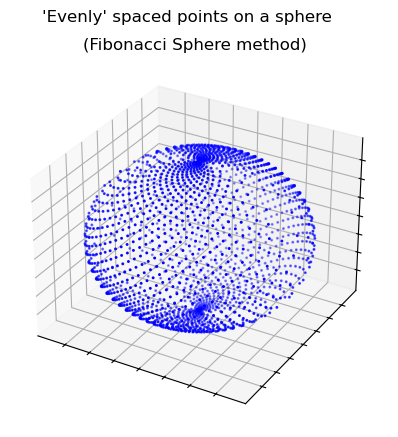

In [14]:
fib_points = convert_to_cartesian(generate_fibonacci_sphere_points(2048))

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(fib_points[:, 0], fib_points[:, 1], fib_points[:, 2], marker = '.', s = 5, c = 'b')

#   Set plot limits and labels
x_max = np.max(np.abs(fib_points[:, 0]))
y_max = np.max(np.abs(fib_points[:, 1]))
z_max = np.max(np.abs(fib_points[:, 2]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_zlim(-z_max, z_max)
ax.set_title('(Fibonacci Sphere method)')
fig.suptitle("'Evenly' spaced points on a sphere")
plt.show()
plt.close()


#### Electrostatic repulsion method
The electrostatic repulsion method is a technique used to distribute points on surfaces, commonly on spheres, such that they are as evenly spaced as possible. This method simulates the repulsive force experienced by charged particles that follow Coulomb's Law, where like charges repel each other. By treating each point as if it carries an equal positive charge, the algorithm distributes them in a way that minimizes the overall potential energy of the system, leading to an even spacing. Imagine each point on the surface as a positively charged particle. When these particles are placed on a sphere, they will move to maximize their distances from each other due to the repulsive electrostatic force. The equilibrium state, where the forces are balanced, represents the solution to the problem of distributing points evenly
1. **Initialization**: Place points randomly on the surface
2. **Force Calculation**: For each point, calculate the net electrostatic repulsive force exerted by all other points
3. **Movement**: Move each point along the direction of the resultant force, proportionally to the magnitude of the force and a chosen step size
4. **Convergence**: Repeat the force calculation and movement steps until the system converges to a stable state, where points no longer move significantly
5. **Projection**: After each iteration, project points back onto the surface to maintain the constraint of staying on the surface

In [15]:
def initial_positions(n):
    """
    Generates n random points on a sphere of radius 1

    Parameters:
    - n:    Number of points

    Returns:
    - A 2D numpy array of Cartesian coordinates [x, y, z] for each point
    """
    coords = np.random.randn(n, 3)
    norms = np.linalg.norm(coords, axis=1, keepdims = True)
    
    return coords / norms


In [16]:
def repulsive_forces(points, epsilon):
    """
    Computes repulsive forces acting on each point due to all other points

    Parameters:
    - points:   A 2D numpy array of coordinates [x, y, z] for each point
    - epsilon:  A small value added to distances to prevent division by zero

    Returns:
    - A numpy array representing force vectors acting on each point
    """
    pairwise_distances = cdist(points, points, 'euclidean')
    np.fill_diagonal(pairwise_distances, np.inf)            #   Prevent division by zero
                                                            #   in force calculations
    # Calculate repulsive force magnitude (inverse square law)
    force_magnitudes = 1.0 / (pairwise_distances ** 2 + epsilon ** 2)
    
    # Calculate direction vectors for all pairs
    direction_vectors = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    
    # Normalize direction vectors to unit vectors
    norms = np.linalg.norm(direction_vectors, axis = 2, keepdims = True)
    
    # Avoid division by zero by setting small norms to 1 (since division result is set to 0)
    norms = np.where(norms == 0, np.inf, norms)
    unit_direction_vectors = direction_vectors / norms
    
    # Calculate forces as vectors
    forces = np.sum(force_magnitudes[:, :, np.newaxis] * unit_direction_vectors, axis = 1)
    
    return forces


In [17]:
def electrostatic_simulate(points, iterations, learning_rate, epsilon, convergence_threshold):
    """
    Simulates the time evolution of a system of points under electrostatic repulsion.

    Parameters:
    - points:                   Initial numpy array of coordinates [x, y, z] for each point
    - iterations:               Number of iterations to simulate.
    - learning_rate:            Scaling factor for the force application.
    - epsilon:                  Tolerance for pairwise distance to avoid division by zero.
    - convergence_threshold:    Maximum movement allowed before considering the system converged

    Returns:
    - The final numpy array of coordinates [x, y, z] for each point
    """
    for i in range(iterations):
        forces = repulsive_forces(points, epsilon)
        delta_points = forces * learning_rate
        points += delta_points
        points /= np.linalg.norm(points, axis = 1, keepdims = True)
        
        # Dynamic learning rate adjustment
        if i % 100 == 99:           #   Adjust the learning rate every 100 iterations
            learning_rate *= 0.9    #   Reduce the learning rate to stabilize convergence
        
        # Check for convergence
        if np.max(np.linalg.norm(delta_points, axis = 1)) < convergence_threshold:
            print(f"Converged after {i + 1} iterations")
            break
    
    return points

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

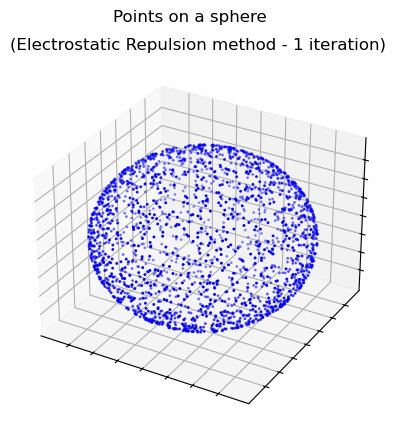

In [18]:
init_points = initial_positions(2048)
first_points = electrostatic_simulate(init_points, 1, 1e-4, 1e-32, 1e-7)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(first_points[:, 0], first_points[:, 1], first_points[:, 2], c = 'b', marker = '.', s = 5)

#   Set plot limits and labels
x_max = np.max(np.abs(first_points[:, 0]))
y_max = np.max(np.abs(first_points[:, 1]))
z_max = np.max(np.abs(first_points[:, 2]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_zlim(-z_max, z_max)
ax.set_title('(Electrostatic Repulsion method - 1 iteration)')
fig.suptitle('Points on a sphere')
plt.show()
plt.close()


In [19]:
# final_points = electrostatic_simulate(init_points, 100000, 1e-4, 1e-32, 1e-7)

# np.savetxt(f'./2D_sphere_points.txt', final_points)

final_points = np.loadtxt("./2D_sphere_points.txt")

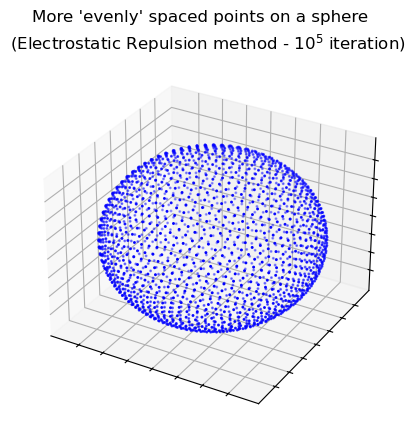

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(final_points[:, 0], final_points[:, 1], final_points[:, 2], c = 'b', marker = '.', s = 5)

#   Set plot limits and labels
x_max = np.max(np.abs(final_points[:, 0]))
y_max = np.max(np.abs(final_points[:, 1]))
z_max = np.max(np.abs(final_points[:, 2]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_zlim(-z_max, z_max)
ax.set_title(r'(Electrostatic Repulsion method - $10^5$ iteration)')
fig.suptitle("More 'evenly' spaced points on a sphere")
plt.show()
plt.close()


#### Pairwise distance analysis

In [21]:
def find_closest_neighbors(points, k):
    """
    Finds the k closest neighbors for each point in the dataset

    Parameters:
    - points:       numpy array of coordinates [x, y, z] for each point
    - k:            number of close neighbors to search for each point

    Returns:
    - indices:      ordered numpy array indices of the closest neighbors (excluding the point itself)
    - distances:    ordered numpy array of distances to the closest neighbors (excluding the point itself)
    """
    tree = cKDTree(points)          #   Query the k+1 nearest neighbors for each point because
                                    #   the query includes the point itself in the results.
    distances, indices = tree.query(points, k = k + 1)
    
    # Exclude the point itself from its list of closest neighbors
    return indices[:, 1:], distances[:, 1:]


In [22]:
def compare_closest_neighbors():
    """
    Compares the closest neighbors' distances for the given points, categorizing
    them into bins based on distance ranges and visualizes the distribution of
    these distances

    Parameters:
    - final_points: numpy array of final coordinates [x, y, z] for each point
    """
    n_neighbors = final_points.shape[0] - 1
    _, neighbors_distances = find_closest_neighbors(final_points, n_neighbors)

    # Flatten distances to work with individual neighbor distances
    flattened_distances = neighbors_distances.flatten()

    low_bin = flattened_distances[flattened_distances <= 0.105]
    mid_bin = flattened_distances[(flattened_distances > 0.105) & (flattened_distances <= 0.125)]
    high_bin = flattened_distances[(flattened_distances > 0.125) & (flattened_distances <= 0.2)]

    print(f'Pairwise difference lower than 0.1 units:           {low_bin.shape[0]}')
    print(f'Pairwise difference between 0.1 and 0.125 units:    {mid_bin.shape[0]}')
    print(f'Pairwise difference between 0.125 and 0.2 units:    {high_bin.shape[0]}')

    plt.figure(figsize = (8, 5))
    plt.hist(neighbors_distances[neighbors_distances <= 0.40], bins = 50, edgecolor = 'black')
    plt.axvline(x = 0.105, ls = '--', lw = 1.5, label = 'optimal maximal pairwise distance')
    plt.xlabel('Distance between neighbors')
    plt.ylabel('Count')
    plt.title(r'Histogram of Neighbor distances ($\Delta d\leq 0.40$)')
    plt.show()
    plt.close()

    plt.figure(figsize = (8, 5))
    plt.hist(neighbors_distances.flatten(), bins = 100, edgecolor = 'black')
    plt.axvline(x = 0.105, ls = '--', lw = 1.5, label = 'optimal maximal pairwise distance')
    plt.xlabel('Distance between neighbors')
    plt.ylabel('Count')
    plt.title('Histogram of Neighbor distances (ALL)')
    plt.show()
    plt.close()

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

Pairwise difference lower than 0.1 units:           12180
Pairwise difference between 0.1 and 0.125 units:    240
Pairwise difference between 0.125 and 0.2 units:    24754


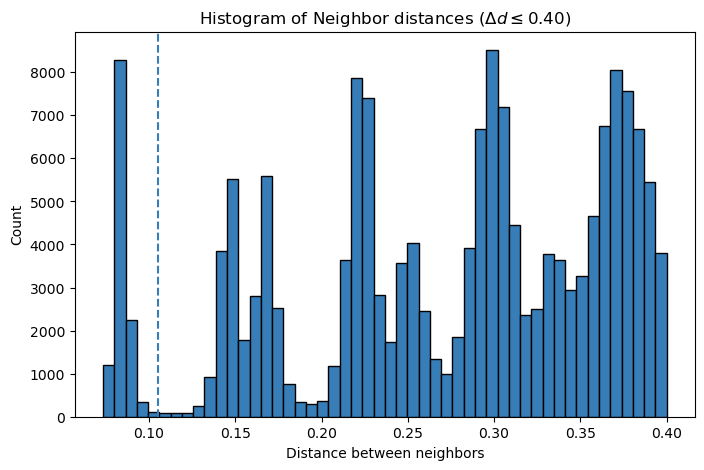

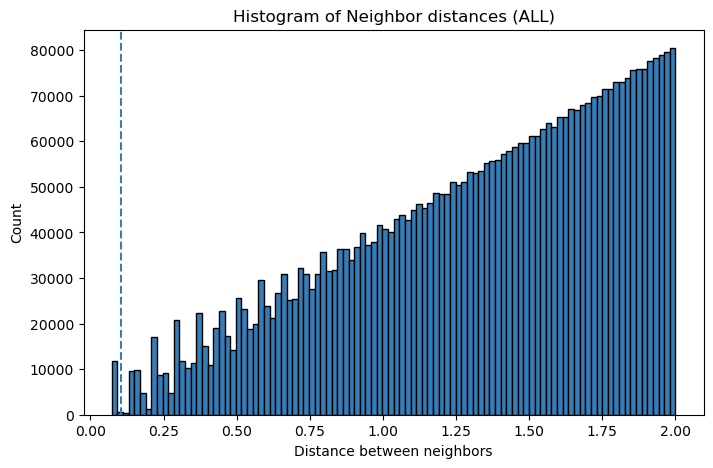

In [23]:
compare_closest_neighbors()

From this we can see clear clusters of 'concentric' points around an arbitrary point. Thus, we can treat points at the closest cluster $< 0.1$ units away as immediate 'neighboring' points
#### Generate 'closest' points

In [24]:
def find_close_neighbors_within_distance(points, distance_threshold = 0.15):
    """
    Finds and lists indices of points within a specified distance for each point in the dataset

    Parameters:
    - points (np.ndarray):              A 2D numpy array of point coordinates [x, y, z]
    - distance_threshold (float):       The distance threshold to consider for neighbors (default is 0.15)

    Returns:
    - close_neighbors (list of tuples): Each tuple contains the indices of points within the specified
                                        distance from each corresponding point in the input array, excluding
                                        the point itself.
    """
    # Compute pairwise distances between all points
    pairwise_distances = cdist(points, points)
    
    # Find indices where distance is within the threshold, excluding self-distance (0)
    close_neighbors = [ tuple(
        np.where((pairwise_distances[i] < distance_threshold) & (pairwise_distances[i] > 0))[0]
        ) for i in range(points.shape[0]) ]
    
    return close_neighbors


## The Model

In [25]:
def calculate_forces_on_points(y, v, neighbors_array, temp_ALPHA, temp_BETA):
    num_points = y.shape[0]
    dvdt = np.zeros(num_points)
    for key, value in enumerate(neighbors_array):
        for neighbor_index in value:
            diff = y[neighbor_index] - y[key]
            sgn = np.sign(diff)

            linear_contribution = temp_ALPHA * diff
            nonlinear_contribution = temp_BETA * diff ** 2
            
            dvdt[key] += linear_contribution + sgn * nonlinear_contribution
    return v, dvdt

## ODE Solvers

In [26]:
#   Runge-Kutta 4th order method (NON-NUMBA)
def non_numba_rk4_step(y, v, dt, func, temp_ALPHA, temp_BETA):
    """
    Runge-Kutta 4th order ODE Solver optimized with Numba
    """
    k1_y, k1_v = func(y, v, temp_ALPHA, temp_BETA)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v, temp_ALPHA, temp_BETA)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v, temp_ALPHA, temp_BETA)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v, temp_ALPHA, temp_BETA)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next


## Initial Conditions

In [27]:
def initialize_sphere(points, neighbors, localized_point):
    """
    Initializes displacement and velocity for a set of points on a sphere. A localized
    point and its immediate neighbors are assigned specific amplitudes

    Parameters:
    - points (np.ndarray):          A 2D numpy array of point coordinates [x, y, z],
                                    where each row represents a point
    - distance_threshold (float):   The distance threshold to consider for identifying
                                    neighbors

    Returns:
    - displacements (np.ndarray):   Initialized displacements for each point
    - velocities (np.ndarray):      Initialized velocities for each point (all zeros)
    """

    # Initialize displacements and velocities with zeros
    y = np.zeros(points.shape[0])
    v = np.zeros(points.shape[0])

    # Set displacement for the localized point (index 0)
    y[localized_point] = 128.0

    # Set displacement for immediate neighbors of the localized point
    for neighbor_index in neighbors[localized_point]:  # Immediate neighbors of the localized point (index 0)
        y[neighbor_index] = 64.0
        for nested_index in neighbors[neighbor_index]:
            if neighbor_index != localized_point:
                y[nested_index] = 32.0

    return y, v


## Simulation

In [28]:
def twoD_sphere_localized_simulator(ode_solver, points, neighbors, localized_point, temp_ALPHA, temp_BETA, temp_dt, temp_time_points):
    """
    Simulates time evolution of oscillators in 2D

    Parameters:
    ode_solver:     ODE Solving algorithm (adapted for 2D)
    init_func:      Function to initialize displacements and velocities
    mode_x, mode_y: Mode numbers for initialization in x and y dimensions
    expression:     Function calculating accelerations (forces) on each particle
    temp_Nx, temp_Ny:         Number of particles in the x and y dimensions

    Returns:
    displacements:  3D array of displacements for each timestep (time, y, x)
    velocities:     3D array of velocities for each timestep (time, y, x)
    """
    # Initialize displacements and velocities
    y, v = initialize_sphere(points, neighbors, localized_point)

    # Initialize arrays to store time evolution data
    num_steps = temp_time_points.shape[0]
    displacements = np.empty((num_steps + 1, points.shape[0]))
    velocities = np.empty((num_steps + 1, points.shape[0]))

    #   Initialize expression function
    expression = lambda y, v, temp_ALPHA, temp_BETA: calculate_forces_on_points(y, v, neighbors, temp_ALPHA, temp_BETA)

    # Store initial conditions
    displacements[0, :] = y
    velocities[0, :] = v

    # Time evolution
    for i, _ in enumerate(temp_time_points, start = 1):
        y, v = ode_solver(y, v, temp_dt, expression, temp_ALPHA, temp_BETA)
        displacements[i, :] = y
        velocities[i, :] = v

    return displacements, velocities


## Analysis
### Animation

In [36]:
def twoD_sphere_plotter(fn, points, displacements, config_str, dt, frame_step):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    norm = Normalize(vmin = displacements.min() / 3, vmax = -displacements.min() / 3)
    cmap = plt.get_cmap('coolwarm')

    colors = cmap(norm(displacements[0]))
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = colors, marker = '.', s = 10)

    #   Set plot limits and labels
    x_max = np.max(np.abs(points[:, 0]))
    y_max = np.max(np.abs(points[:, 1]))
    z_max = np.max(np.abs(points[:, 2]))
    ax.set_axis_off()
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)
    ax.set_zlim(-z_max, z_max)
    ax.set_title(r'(Electrostatic Repulsion method - $10^5$ iteration)')

    # Add a color bar
    mappable = ScalarMappable(norm = norm, cmap = cmap)
    fig.colorbar(mappable, ax = ax, label='Displacement (units)')
    # ax.view_init(elev = 30, azim = 0)
    fig.suptitle(f'{fn} ({displacements.shape[1]} particles)')

    def update(frame):
        """
        Update function for the animation
        """
        displacements_new = displacements[frame]
        colors_new = cmap(norm(displacements_new))
        scatter.set_facecolors(colors_new)
        # ax.azim = (frame // (frame_step * 2)) % 360
        ax.set_title(f'Time: {frame * dt:.3f} units')

        return scatter,

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, displacements.shape[0], frame_step),
                        blit = True)

    output_path = f'./temp/2D/{config_str}/{fn}_flat.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    return output_path


In [30]:
local_neighbors = find_close_neighbors_within_distance(final_points, 0.11)

In [33]:
init_constants(temp_N = 150, temp_BETA = 1.0, temp_N_MODES = 5, temp_t_max = 1e2)
displacements_2D_periodic, _ = twoD_sphere_localized_simulator(non_numba_rk4_step, final_points, local_neighbors, 1, ALPHA, BETA, DT, TIME_POINTS)


In [37]:
set_frame_step(displacements_2D_periodic.shape[0], 10)
#   Plot animations
output_3 = twoD_sphere_plotter('displacements_2D_periodic', final_points, displacements_2D_periodic, CONFIG_STR, DT, FRAME_STEP)
display(Video(output_3))
